# Imports

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [ ]:
def calculate_moving_average(trajectory, window_size):
    """
    Calculate the moving average of a given trajectory.

    Parameters:
    - trajectory: numpy array, input trajectory data
    - window_size: int, size of the moving average window

    Returns:
    - smoothed_curve: numpy array, the moving average of the input trajectory
    """

    # Pad the beginning and end of the trajectory to handle edge effects
    pad_head = np.repeat(trajectory[0], window_size // 2)
    pad_tail = np.repeat(trajectory[-1], window_size // 2)
    padded_trajectory = np.concatenate((pad_head, trajectory, pad_tail))

    # Create a simple moving average filter
    moving_avg_filter = np.ones(window_size) / window_size

    # Apply the moving average filter using convolution
    smoothed_curve = np.convolve(padded_trajectory, moving_avg_filter, mode='valid')

    # Trim the result to match the original trajectory length
    return smoothed_curve[:len(trajectory)]


In [ ]:
def smooth_trajectory(trajectory, window_size):
    """
    Smooth the given trajectory by applying a moving average to each column.

    Parameters:
    - trajectory: numpy array, input trajectory data
    - window_size: int, size of the moving average window

    Returns:
    - smoothed_trajectory: numpy array, the smoothed trajectory
    """

    # Create a copy of the input trajectory to store the smoothed result
    smoothed_trajectory = np.copy(trajectory)

    # Iterate over each column in the trajectory and apply moving average
    for column_index in range(smoothed_trajectory.shape[1]):
        # Apply moving average to the current column using the helper function
        smoothed_trajectory[:, column_index] = calculate_moving_average(
            trajectory[:, column_index],
            window_size
        )

    # Return the smoothed trajectory
    return smoothed_trajectory

In [ ]:
def scale_frame_with_border(frame, scaling_percentage):
    """
    Scale the input frame with a border using a given scaling percentage.

    Parameters:
    - frame: numpy array, input image frame
    - scaling_percentage: float, percentage by which to scale the frame

    Returns:
    - scaled_frame: numpy array, the scaled frame with a border
    """

    # Get the shape of the input frame
    frame_shape = frame.shape

    # Calculate the scale factor based on the provided percentage
    scale_factor = 1.0 + scaling_percentage / 100.0

    # Calculate the center coordinates of the frame
    center_x, center_y = frame_shape[1] / 2, frame_shape[0] / 2

    # Create a transformation matrix for scaling
    transformation_matrix = cv2.getRotationMatrix2D((center_x, center_y), 0, scale_factor)

    # Apply the scaling transformation using warpAffine
    scaled_frame = cv2.warpAffine(frame, transformation_matrix, (frame_shape[1], frame_shape[0]))

    # Return the scaled frame with a border
    return scaled_frame


# Parameters definition

In [ ]:
# Create interactive sliders for tuning parameters
max_corners = widgets.IntSlider(value=200, min=50, max=500, description='Max Corners:', continuous_update=True)
quality_level = widgets.FloatSlider(value=0.01, min=0.001, max=0.1, description='Quality Level:', continuous_update=True)
min_distance = widgets.IntSlider(value=50, min=10, max=100, description='Min Distance:', continuous_update=True)
block_size = widgets.IntSlider(value=3, min=2, max=5, description='Block Size:', continuous_update=True)
window_size = widgets.IntSlider(value=50, min=0, max=100, description='Window Size:', continuous_update=True)

# Arrange the sliders in a vertical box layout
slider_box = widgets.VBox([max_corners, quality_level, min_distance, block_size, window_size])

# Display the sliders
slider_box

In [ ]:
# Get the current values of the interactive sliders
max_corners_value = max_corners.value
quality_level_value = quality_level.value
min_distance_value = min_distance.value
block_size_value = block_size.value
window_size_value = window_size.value


# Main code

In [ ]:
input_video_path = '/content/white mountain view.mp4'  #@param

# Open the input video file
video = cv2.VideoCapture(input_video_path)

# Get informations about the video
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))  # Width of each frame
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Height of each frame
fps = video.get(cv2.CAP_PROP_FPS)  # Frames per second of the video

# video codec
output_codec = 'MJPG'  #@param
output_fourcc = cv2.VideoWriter_fourcc(*output_codec)

# Output settings
output_video_name = 'output_test.avi'  #@param
video_out = cv2.VideoWriter(output_video_name, output_fourcc, fps, (2 * width, height))


In [ ]:
# Read the first frame from the video
success, first_frame = video.read()

# Check if reading the first frame was successful
if not success:
    raise ValueError("Cannot read the video file")

# Convert the first frame to grayscale
first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Initialize an array to store the transformations for each frame
transforms = np.zeros((num_frames - 1, 3), np.float32)

# Video Loop
for i in range(num_frames - 2):
    # Shi-Tomasi feature detection
    first_shi_points = cv2.goodFeaturesToTrack(first_gray,
                                       maxCorners=max_corners_value,
                                       qualityLevel=quality_level_value,
                                       minDistance=min_distance_value,
                                       blockSize=block_size_value)

    # Read the next frame
    success, next_frame = video.read()
    if not success:
        break

    # Convert the current frame to grayscale
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow using Lucas-Kanade method
    next_points, status, err = cv2.calcOpticalFlowPyrLK(first_gray, next_gray, first_shi_points, None)

    # Select only the points with successful optical flow calculation
    valid_points = np.where(status == 1)[0]
    first_shi_points = first_shi_points[valid_points]
    next_points = next_points[valid_points]

    # Estimate an affine transformation matrix between the two sets of points
    Msc, _ = cv2.estimateAffine2D(first_shi_points, next_points)

    # Extract translation and rotation parameters from the transformation matrix
    dx, dy = Msc[0, 2], Msc[1, 2]
    da = np.arctan2(Msc[1, 0], Msc[0, 0])

    # Store the transformation parameters in the array
    transforms[i] = [dx, dy, da]

    # Update the previous frame for the next iteration
    first_gray = next_gray

# Cumulative sum of transformations to get the trajectory
trajectory = np.cumsum(transforms, axis=0)

# Smooth the trajectory using the specified window size
smoothed_trajectory = smooth_trajectory(trajectory, window_size_value)
# Additional smoothed trajectories with different window sizes for comparison
smoothed_trajectory_50 = smooth_trajectory(trajectory, 50)
smoothed_trajectory_75 = smooth_trajectory(trajectory, 75)

# Calculate the difference between the smoothed and original trajectories
difference = smoothed_trajectory - trajectory

# Apply the difference to the original transformations to get smoothed transformations
transforms_smooth = transforms + difference

# Plots

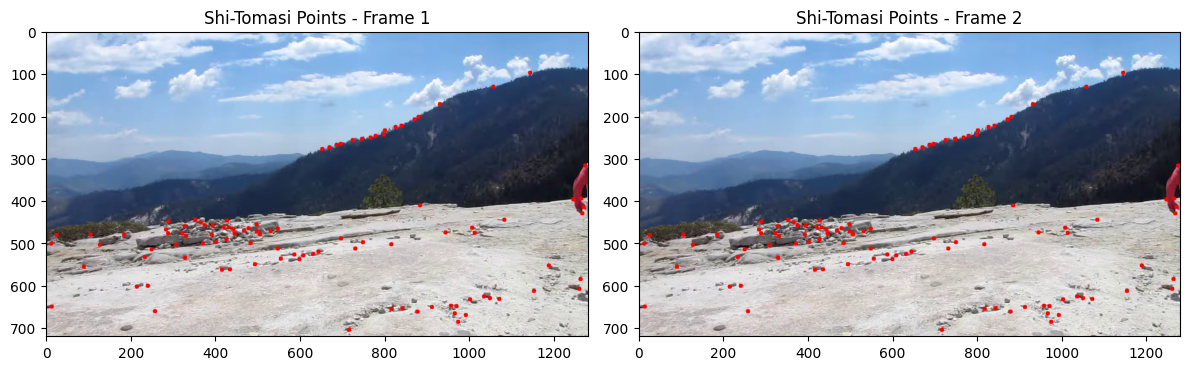

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Reading the first frame again
first_frame = 0
video.set(cv2.CAP_PROP_POS_FRAMES, first_frame)
_, frame1 = video.read()
_, frame2 = video.read()

# Convert frames to grayscale
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Extracting x, y coordinates of Shi-Tomasi points for the first frame
first_shi_points = cv2.goodFeaturesToTrack(frame1_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)
first_shi_points = np.int0(first_shi_points)  # Convert to integer type

# Draw Shi-Tomasi points on the first frame
for i in first_shi_points:
    x, y = i.ravel()
    cv2.circle(frame1, (x, y), 5, (0, 0, 255), -1)  # Draw a red dot for each detected point

# Plot the Shi-Tomasi points of the first frame on the left subplot
axes[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Shi-Tomasi Points - Frame 1')

# Extracting x, y coordinates of Shi-Tomasi points for the second frame
next_points = cv2.goodFeaturesToTrack(frame2_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)
next_points = np.int0(next_points)  # Convert to integer type

# Draw Shi-Tomasi points on the second frame
for i in next_points:
    x, y = i.ravel()
    cv2.circle(frame2, (x, y), 5, (0, 0, 255), -1)  # Draw a red dot for each detected point

# Plot the Shi-Tomasi points of the second frame on the right subplot
axes[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Shi-Tomasi Points - Frame 2')

# Display the plot
plt.tight_layout()
plt.show()


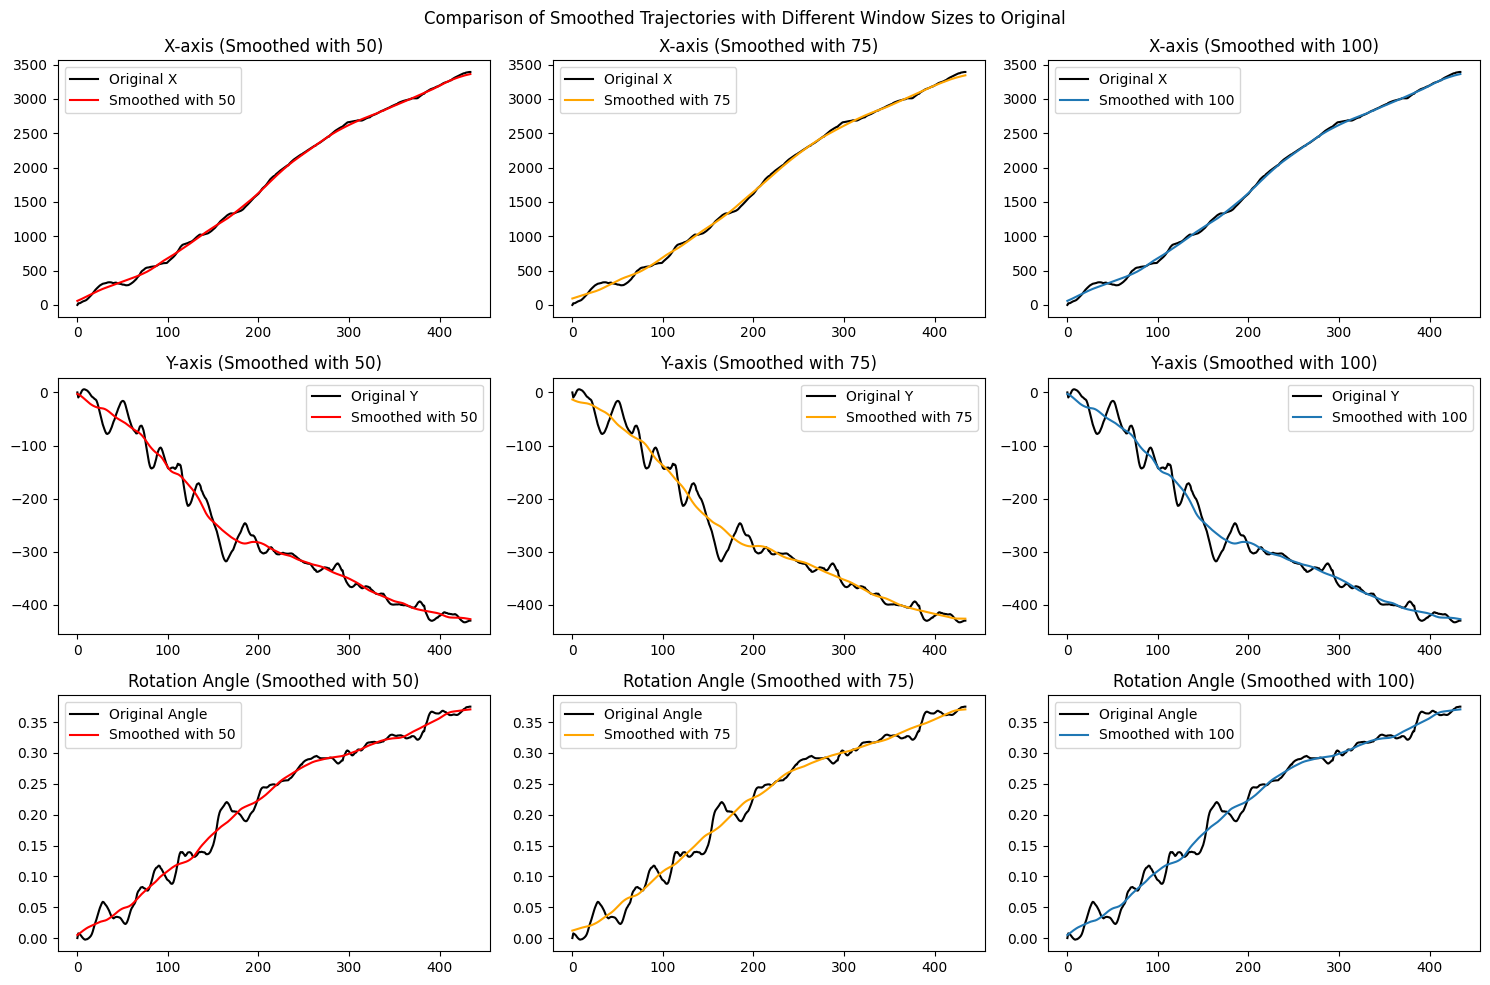

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot for comparison: 50 vs. original
axs[0, 0].plot(trajectory[:, 0], color='black', label='Original X')
axs[0, 0].plot(smoothed_trajectory_50[:, 0], color='red', label='Smoothed with 50')
axs[0, 0].set_title('X-axis (Smoothed with 50)')
axs[0, 0].legend()

axs[1, 0].plot(trajectory[:, 1], color='black', label='Original Y')
axs[1, 0].plot(smoothed_trajectory_50[:, 1], color='red', label='Smoothed with 50')
axs[1, 0].set_title('Y-axis (Smoothed with 50)')
axs[1, 0].legend()

axs[2, 0].plot(trajectory[:, 2], color='black', label='Original Angle')
axs[2, 0].plot(smoothed_trajectory_50[:, 2], color='red',label='Smoothed with 50')
axs[2, 0].set_title('Rotation Angle (Smoothed with 50)')
axs[2, 0].legend()

# Plot for comparison: 75 vs. original
axs[0, 1].plot(trajectory[:, 0], color='black', label='Original X')
axs[0, 1].plot(smoothed_trajectory_75[:, 0], color='orange', label='Smoothed with 75')
axs[0, 1].set_title('X-axis (Smoothed with 75)')
axs[0, 1].legend()

axs[1, 1].plot(trajectory[:, 1], color='black', label='Original Y')
axs[1, 1].plot(smoothed_trajectory_75[:, 1], color='orange',label='Smoothed with 75')
axs[1, 1].set_title('Y-axis (Smoothed with 75)')
axs[1, 1].legend()

axs[2, 1].plot(trajectory[:, 2], color='black', label='Original Angle')
axs[2, 1].plot(smoothed_trajectory_75[:, 2],color='orange', label='Smoothed with 75')
axs[2, 1].set_title('Rotation Angle (Smoothed with 75)')
axs[2, 1].legend()

# Plot for comparison: 100 vs. original
axs[0, 2].plot(trajectory[:, 0], color='black', label='Original X')
axs[0, 2].plot(smoothed_trajectory[:, 0], label='Smoothed with 100')
axs[0, 2].set_title('X-axis (Smoothed with 100)')
axs[0, 2].legend()

axs[1, 2].plot(trajectory[:, 1], color='black', label='Original Y')
axs[1, 2].plot(smoothed_trajectory[:, 1], label='Smoothed with 100')
axs[1, 2].set_title('Y-axis (Smoothed with 100)')
axs[1, 2].legend()

axs[2, 2].plot(trajectory[:, 2], color='black', label='Original Angle')
axs[2, 2].plot(smoothed_trajectory[:, 2], label='Smoothed with 100')
axs[2, 2].set_title('Rotation Angle (Smoothed with 100)')
axs[2, 2].legend()

plt.suptitle('Comparison of Smoothed Trajectories with Different Window Sizes to Original')
plt.tight_layout()
plt.show()


# Rewriting video

In [ ]:
scaling_percentage = 10 #@param

In [ ]:
# Set the video capture position to the first frame
first_frame = 0
video.set(cv2.CAP_PROP_POS_FRAMES, first_frame)

# Loop through the frames to stabilize and write to the output video
for i in range(num_frames - 2):
    # Read the current frame from the stabilized video
    success, frame_input = video.read()
    if not success:
        break

    # Extract the smoothed transformation parameters
    dx = transforms_smooth[i, 0]
    dy = transforms_smooth[i, 1]
    da = transforms_smooth[i, 2]

    # Create an affine transformation matrix
    Msc = np.zeros((2, 3), np.float32)
    Msc[0, 0] = np.cos(da)
    Msc[0, 1] = -np.sin(da)
    Msc[1, 0] = np.sin(da)
    Msc[1, 1] = np.cos(da)
    Msc[0, 2] = dx
    Msc[1, 2] = dy

    # Apply the affine transformation to stabilize the frame
    affine_frame = cv2.warpAffine(frame_input, Msc, (width, height))

    # Scale the stabilized frame with a border
    frame_stabilized = scale_frame_with_border(affine_frame, scaling_percentage)

    # Concatenate the original and stabilized frames horizontally
    frame_output = cv2.hconcat([frame_input, frame_stabilized])

    # Wait for a short duration and write the frame to the output video
    cv2.waitKey(10)
    video_out.write(frame_output)

# Release the video capture and writer objects
video.release()
video_out.release()

# Close all OpenCV windows
cv2.destroyAllWindows()